In [2]:
import numpy as np
import rasterio
import rioxarray
import matplotlib.pyplot as plt
import gc

def calculate_difference(interferogram1, interferogram2,chunk_size=1048):
    """优化后的差异计算函数，增加分块有效性检查和内存管理"""
    # 统一使用xarray对象获取形状
    if interferogram1.shape != interferogram2.shape:
        raise ValueError("输入TIFF文件必须具有相同尺寸")

    # 获取数据数组并初始化输出
    data1 = interferogram1.data
    data2 = interferogram2.data
    rows, cols = data1.shape
    difference = np.zeros((rows, cols), dtype=np.float32)
    
    # 优化分块策略防止边缘块为零尺寸
    chunk_rows = max(1, min(chunk_size, rows))
    chunk_cols = max(1, min(chunk_size, cols))

    for i in range(0, rows, chunk_rows):
        for j in range(0, cols, chunk_cols):
            # 计算实际分块范围
            end_i = min(i + chunk_rows, rows)
            end_j = min(j + chunk_cols, cols)
            
            # 跳过零尺寸分块
            if end_i <= i or end_j <= j:
                continue

            # 提取数据块并验证有效性
            chunk1 = data1[i:end_i, j:end_j]
            chunk2 = data2[i:end_i, j:end_j]
            
            # 计算归一化差异（带稳定性处理）
            epsilon = 1e-8
            denominator = chunk1 + chunk2 + epsilon
            valid_mask = denominator != 0
            diff_chunk = np.full_like(chunk1, np.nan, dtype=np.float32)
            diff_chunk[valid_mask] = (chunk1[valid_mask] - chunk2[valid_mask]) / denominator[valid_mask]

            # 写入结果
            difference[i:end_i, j:end_j] = diff_chunk

    # 综合掩膜处理
    mask = np.isnan(data1) | np.isnan(data2) | (data1 == 0) | (data2 == 0)
    difference[mask] = np.nan  # 统一设置为NaN便于后续处理

    return difference
def process_calculate_difference(tif_path1, tif_path2, chunk_size=1048, show_plot=True, output_suffix="phaseSTD"):
    """
    相位标准差处理全流程封装
    
    参数：
    tif_path (str): 输入TIFF文件路径
    chunk_size (int): 分块计算尺寸，默认1048
    show_plot (bool): 是否显示可视化图表
    output_suffix (str): 输出文件后缀标识
    """
    # 加载数据
    ifg1 = rioxarray.open_rasterio(tif_path1)[0]
    ifg2 = rioxarray.open_rasterio(tif_path2)[0]
    # 计算标准差
    phase_std = calculate_difference(ifg1, ifg2, chunk_size=chunk_size)
    
    # 掩膜处理
    phase_std = np.where(np.isnan(ifg1), np.nan, 
                        np.where(ifg1 == 0, 0, phase_std))
    phase_std = np.where(np.isnan(ifg2), np.nan, 
                        np.where(ifg2 == 0, 0, phase_std))
    # 保存numpy格式
    np.save(tif_path2.replace(".tif", f"_{output_suffix}.npy"), phase_std)
    
    # 读取原始地理参数
    with rasterio.open(tif_path2) as src:
        transform = src.transform
        width = src.width
        height = src.height
        dtype = src.dtypes[0]
        nodata = src.nodatavals[0]
        crs = src.crs
    
    # 保存为GeoTIFF
    output_tif = tif_path2.replace(".tif", f"_{output_suffix}.tif")
    with rasterio.open(
        output_tif,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=dtype,
        crs=crs,
        transform=transform,
        nodata=nodata,
    ) as dst:
        dst.write(phase_std, 1)
    
    # 可视化
    if show_plot:
        plt.figure(figsize=(12, 6))
        plt.imshow(phase_std, cmap="viridis", aspect="auto")
        plt.colorbar(label="Phase Standard Deviation")
        plt.title(f"Processed Result: {output_suffix}")
        plt.tight_layout()
        plt.show()
    
    # 内存清理
    del ifg1,ifg2, phase_std
    gc.collect()


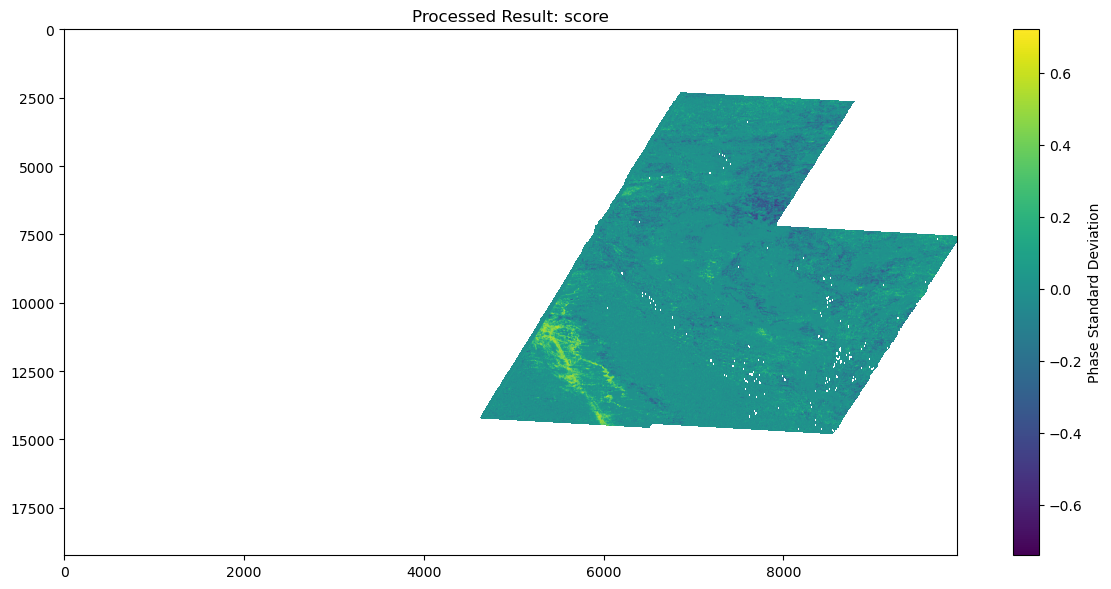

In [3]:
process_calculate_difference(
        "/penguin/yangyanchen/25EQ_myanmar/s1_d033/pre/geo_phsig.cor.tif",
        "/penguin/yangyanchen/25EQ_myanmar/s1_d033/co/geo_phsig.cor.tif",
        chunk_size=2048,
        show_plot=True,
        output_suffix="score"
    )

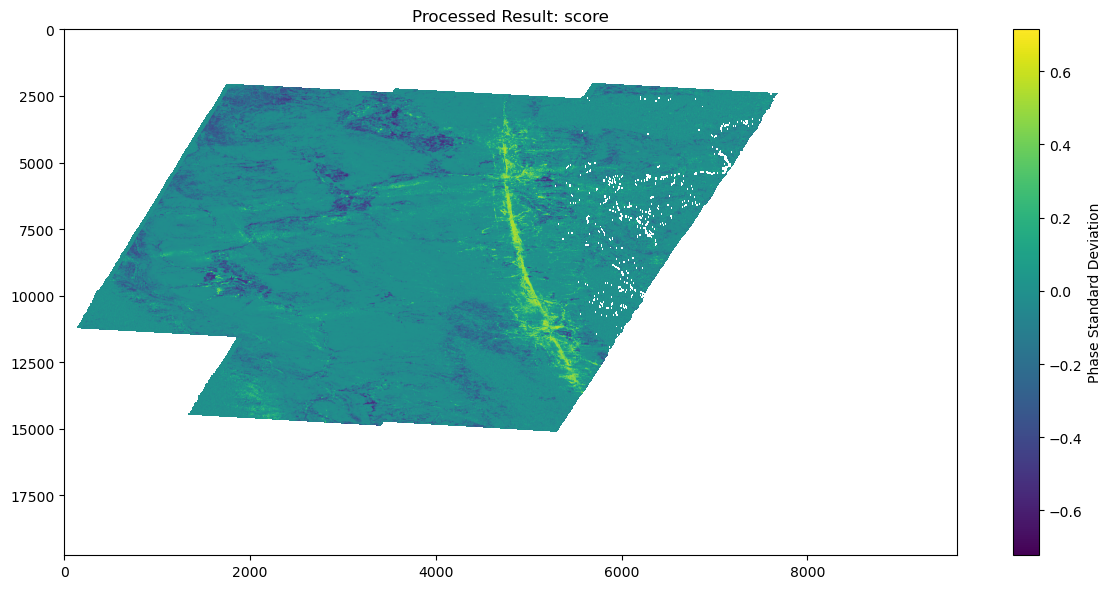

In [5]:
process_calculate_difference(
        "/penguin/yangyanchen/25EQ_myanmar/s1_d106/pre/geo_phsig.cor.tif",
        "/penguin/yangyanchen/25EQ_myanmar/s1_d106/co/geo_phsig.cor.tif",
        chunk_size=2048,
        show_plot=True,
        output_suffix="score"
    )

In [ ]:
import numpy as np
import rasterio
import rioxarray
import matplotlib.pyplot as plt
import gc

def process_norm_mask(tif_path, show_plot=True, output_suffix="3norm_mask"):
    """
    正态分布阈值掩膜生成
    
    参数：
    tif_path (str): 输入TIFF路径
    show_plot (bool): 是否显示可视化
    output_suffix (str): 输出文件后缀
    """
    # 加载数据并获取地理参数
    ifg = rioxarray.open_rasterio(tif_path)[0]
    delta_coh = ifg.values
    original_nodata = ifg.rio.nodata if ifg.rio.nodata is not None else 0
    
    # 从rioxarray直接获取地理参数
    transform = ifg.rio.transform()
    crs = ifg.rio.crs
    height, width = ifg.rio.shape

    # 数据预处理
    valid_mask = ~np.isnan(delta_coh) & (delta_coh != original_nodata)
    valid_values = delta_coh[valid_mask]  # 直接使用一维数组

    # 正态分布拟合计算阈值
    mean = np.mean(valid_values)
    std_dev = np.std(valid_values)
    threshold = 0.5242
    print(threshold)
    # 生成结果矩阵
    result = np.full_like(delta_coh, fill_value=original_nodata, dtype=delta_coh.dtype)
    result[(delta_coh >= threshold) & valid_mask] = delta_coh[(delta_coh >= threshold) & valid_mask]

    # 保存GeoTIFF
    output_tif = tif_path.replace(".tif", f"_{output_suffix}.tif")
    with rasterio.open(
        output_tif,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=result.dtype,
        crs=crs,
        transform=transform,
        nodata=original_nodata
    ) as dst:
        dst.write(result, 1)

    # 可视化
    if show_plot:
        plt.figure(figsize=(12, 6))
        plt.imshow(np.where(result == original_nodata, np.nan, result), 
                 cmap="viridis", aspect="auto")
        plt.colorbar(label="Original Value")
        plt.title(f"Threshold: μ + 2σ = {threshold:.2f}")
        plt.show()

    # 内存清理
    del ifg, delta_coh, result
    gc.collect()

In [8]:
import numpy as np
import rasterio
import rioxarray
import matplotlib.pyplot as plt
import gc

def process_dual_norm_mask(tif_path1, tif_path2, tif_path3, tif_path4, show_plot=True, output_suffix="norm_mask"):
    """
    双文件正态分布阈值掩膜生成
    
    参数：
    tif_path1 (str): 第一个输入TIFF路径
    tif_path2 (str): 第二个输入TIFF路径
    show_plot (bool): 是否显示可视化
    output_suffix (str): 输出文件后缀
    """
    # 加载第一个数据集
    ifg1 = rioxarray.open_rasterio(tif_path1)[0]
    delta_coh1 = ifg1.values
    nodata1 = ifg1.rio.nodata if ifg1.rio.nodata is not None else 0
    valid_mask1 = ~np.isnan(delta_coh1) & (delta_coh1 != nodata1)
    valid_values1 = delta_coh1[valid_mask1]
    transform1 = ifg1.rio.transform()
    crs1 = ifg1.rio.crs
    height1, width1 = ifg1.rio.shape

    # 加载第二个数据集
    ifg2 = rioxarray.open_rasterio(tif_path2)[0]
    delta_coh2 = ifg2.values
    nodata2 = ifg2.rio.nodata if ifg2.rio.nodata is not None else 0
    valid_mask2 = ~np.isnan(delta_coh2) & (delta_coh2 != nodata2)
    valid_values2 = delta_coh2[valid_mask2]
    transform2 = ifg2.rio.transform()
    crs2 = ifg2.rio.crs
    height2, width2 = ifg2.rio.shape
        # 加载第二个数据集
    ifg3 = rioxarray.open_rasterio(tif_path3)[0]
    delta_coh3 = ifg3.values
    nodata3 = ifg3.rio.nodata if ifg3.rio.nodata is not None else 0
    valid_mask3 = ~np.isnan(delta_coh3) & (delta_coh3 != nodata3)
    valid_values3 = delta_coh3[valid_mask3]
    transform3 = ifg3.rio.transform()
    crs3 = ifg3.rio.crs
    height3, width3 = ifg3.rio.shape

        # 加载第二个数据集
    ifg4 = rioxarray.open_rasterio(tif_path4)[0]
    delta_coh4 = ifg4.values
    nodata4 = ifg4.rio.nodata if ifg4.rio.nodata is not None else 0
    valid_mask4 = ~np.isnan(delta_coh4) & (delta_coh4 != nodata4)
    valid_values4 = delta_coh4[valid_mask4]
    transform4 = ifg4.rio.transform()
    crs4 = ifg4.rio.crs
    height4, width4 = ifg4.rio.shape

    # 合并有效数据计算统计量
    combined_valid = np.concatenate([valid_values1, valid_values2])
    mean = np.mean(combined_valid)
    std_dev = np.std(combined_valid)
    threshold = mean + 3 * std_dev
    print(f"Combined statistics - Mean: {mean:.4f}, Std: {std_dev:.4f}, Threshold: {threshold:.4f}")


# 示例用法
process_dual_norm_mask(
    "/penguin/yangyanchen/25EQ_myanmar/s1_d033/co/geo_phsig.cor_score.tif",
    "/penguin/yangyanchen/25EQ_myanmar/s1_d106/co/geo_phsig.cor_score.tif",
    "/penguin/yangyanchen/25EQ_myanmar/s1_d106/co/merged/geo_phsig.cor_score.tif",
    "/penguin/yangyanchen/25EQ_myanmar/s1_d033/co/merged/geo_phsig.cor_score.tif",
    show_plot=True
)

Combined statistics - Mean: -0.0206, Std: 0.1509, Threshold: 0.4321


In [9]:
import numpy as np
import rasterio
import rioxarray
import matplotlib.pyplot as plt
import gc

def process_norm_mask(tif_path, show_plot=True, output_suffix="3norm_mask"):
    """
    正态分布阈值掩膜生成
    
    参数：
    tif_path (str): 输入TIFF路径
    show_plot (bool): 是否显示可视化
    output_suffix (str): 输出文件后缀
    """
    # 加载数据并获取地理参数
    ifg = rioxarray.open_rasterio(tif_path)[0]
    delta_coh = ifg.values
    original_nodata = ifg.rio.nodata if ifg.rio.nodata is not None else 0
    
    # 从rioxarray直接获取地理参数
    transform = ifg.rio.transform()
    crs = ifg.rio.crs
    height, width = ifg.rio.shape

    # 数据预处理
    valid_mask = ~np.isnan(delta_coh) & (delta_coh != original_nodata)
    valid_values = delta_coh[valid_mask]  # 直接使用一维数组

    # 正态分布拟合计算阈值
    mean = np.mean(valid_values)
    std_dev = np.std(valid_values)
    threshold = 0.4321
    print(threshold)
    # 生成结果矩阵
    result = np.full_like(delta_coh, fill_value=original_nodata, dtype=delta_coh.dtype)
    result[(delta_coh >= threshold) & valid_mask] = delta_coh[(delta_coh >= threshold) & valid_mask]

    # 保存GeoTIFF
    output_tif = tif_path.replace(".tif", f"_{output_suffix}.tif")
    with rasterio.open(
        output_tif,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=result.dtype,
        crs=crs,
        transform=transform,
        nodata=original_nodata
    ) as dst:
        dst.write(result, 1)

    # 可视化
    if show_plot:
        plt.figure(figsize=(12, 6))
        plt.imshow(np.where(result == original_nodata, np.nan, result), 
                 cmap="viridis", aspect="auto")
        plt.colorbar(label="Original Value")
        plt.title(f"Threshold: μ + 2σ = {threshold:.2f}")
        plt.show()

    # 内存清理
    del ifg, delta_coh, result
    gc.collect()

0.4321


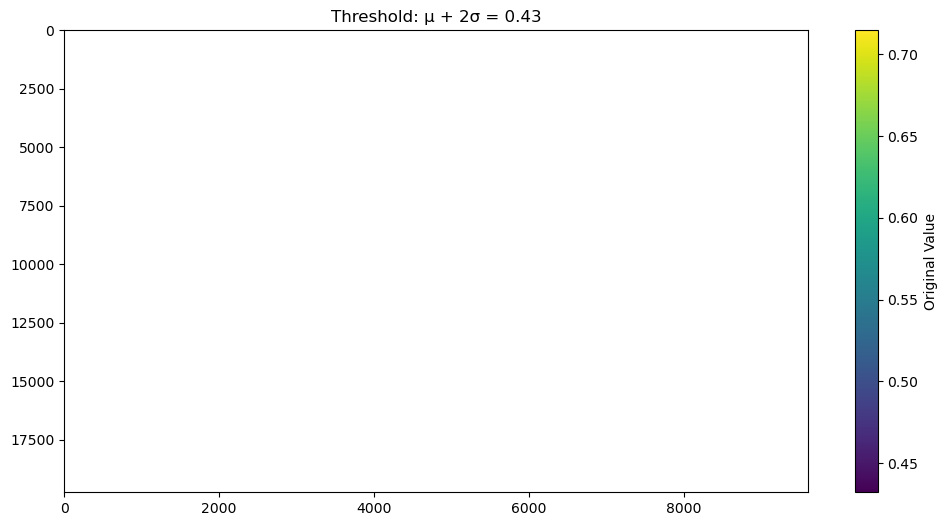

In [10]:
#    "/penguin/yangyanchen/25EQ_myanmar/s1_a143/co/merged/geo_phsig.cor_score.tif",
#    "/penguin/yangyanchen/25EQ_myanmar/s1_a070/co/merged/geo_phsig.cor_score.tif",
#    "/penguin/yangyanchen/25EQ_myanmar/s1_d106/co/merged/geo_phsig.cor_score.tif",
#    "/penguin/yangyanchen/25EQ_myanmar/s1_d033/co/merged/geo_phsig.cor_score.tif",
process_norm_mask("/penguin/yangyanchen/25EQ_myanmar/s1_d106/co/geo_phsig.cor_score.tif", show_plot=True)

0.4321


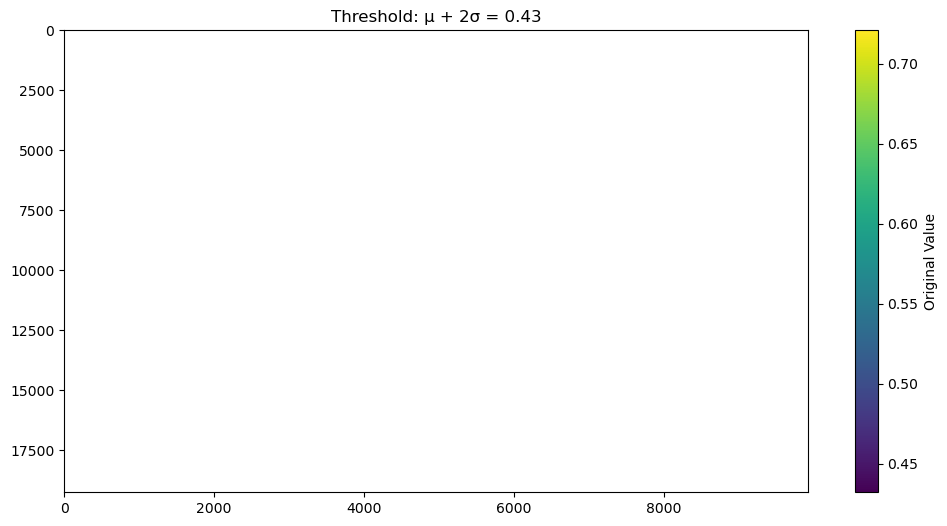

In [11]:
process_norm_mask("/penguin/yangyanchen/25EQ_myanmar/s1_d033/co/geo_phsig.cor_score.tif", show_plot=True)

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is gdal .tif file: /penguin/yangyanchen/25EQ_myanmar/s1_d106/co/geo_phsig.cor_score_3norm_mask.tif in float32 format
file size in y/x: (19749, 9609)
num of datasets in file geo_phsig.cor_score_3norm_mask.tif: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 9609, 19749)
subset coverage in y/x: (0, 0, 9609, 19749)
data   coverage in lat/lon: (94.0, 24.0, 97.99988408019031, 16.49992934415293)
subset coverage in lat/lon: (94.0, 24.0, 97.99988408019031, 16.49992934415293)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: geo_phsig.cor_score_3norm_mask.tif
figure size : [5.3, 8.0]
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.4321, 0.7147491] 1
display range: [0.0, 1.0] 1
reading DEM: elevation_m

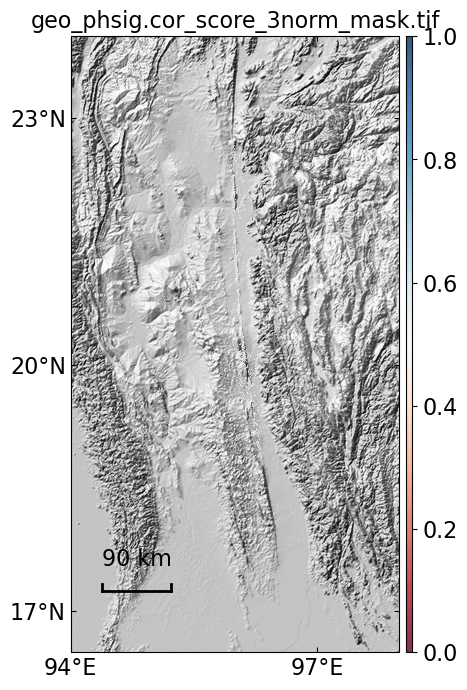

In [13]:
import os
import numpy as np
import platform
from matplotlib import pyplot as plt
from mintpy.utils import ptime, readfile, writefile, isce_utils, utils as ut, plot as pp
from mintpy.cli import geocode, view
from mintpy.view import prep_slice, plot_slice
dis_file = '/penguin/yangyanchen/25EQ_myanmar/s1_d106/co/geo_phsig.cor_score_3norm_mask.tif'
dem_file = os.path.join(f'/penguin/yangyanchen/25EQ_myanmar/DEM/elevation_mli.dem')
#flt_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 '
cmd += f'-c RdBu -v 0 1 --lalo-label --lalo-step 3 --cbar-nbins 5 --scalebar 0.2 0.20 0.10 '
view.main(cmd.split())

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is gdal .tif file: /penguin/yangyanchen/25EQ_myanmar/s1_d033/co/geo_phsig.cor_score_3norm_mask.tif in float32 format
file size in y/x: (19242, 9928)
num of datasets in file geo_phsig.cor_score_3norm_mask.tif: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 9928, 19242)
subset coverage in y/x: (0, 0, 9928, 19242)
data   coverage in lat/lon: (94.0, 24.0, 98.00011282943336, 16.50009470395329)
subset coverage in lat/lon: (94.0, 24.0, 98.00011282943336, 16.50009470395329)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: geo_phsig.cor_score_3norm_mask.tif
figure size : [5.3, 8.0]
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.4321004, 0.7209699] 1
display range: [0.0, 1.0] 1
reading DEM: elevatio

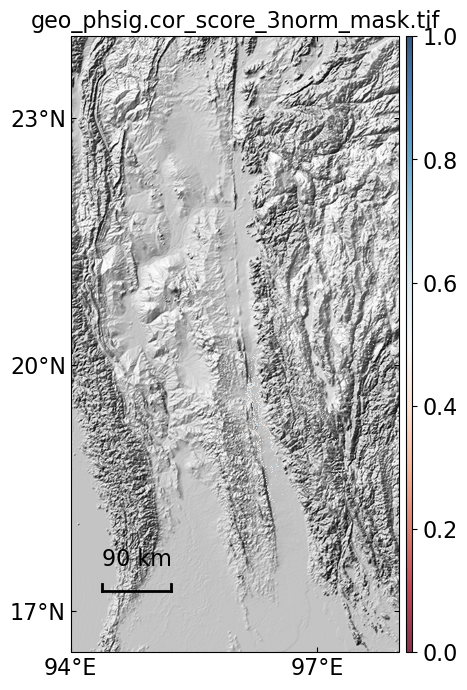

In [14]:
dis_file = '/penguin/yangyanchen/25EQ_myanmar/s1_d033/co/geo_phsig.cor_score_3norm_mask.tif'
dem_file = os.path.join(f'/penguin/yangyanchen/25EQ_myanmar/DEM/elevation_mli.dem')
#flt_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 '
cmd += f'-c RdBu -v 0 1 --lalo-label --lalo-step 3 --cbar-nbins 5 --scalebar 0.2 0.20 0.10 '
view.main(cmd.split())